<a href="https://colab.research.google.com/github/askery/portfolio_optimization/blob/main/portfolio_optimization_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Portfolio Optimization**

Author: Askery Canabarro

References: Check sections for more references

In [20]:
%%capture           
!pip install qiskit

In [21]:
#
import warnings
warnings.filterwarnings('ignore')
# Qiskit for QAOA, VQE etc
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
# Get stock prices
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [22]:
# set number of assets (= number of qubits)
#stocks =  ['BRKM5.SA', 'ITUB4.SA', 'VALE3.SA', 'KLBN4.SA'] # Braskem, Itaú, Vale and Kablin -> price in BRL Brazilian Real (R$)
stocks =  ['AAPL', 'NKE', 'GOOGL', 'AMZN'] # Apple, Nike, Google and Amazon -> price in USD
# 
df         = pdr.get_data_yahoo(stocks, start="2016-01-01", end="2021-09-20")
#
df         = df['Close'] # Close price only
num_assets = len(stocks) # number of assets == 4
#seed       = 123
# return and covariance (dataframe)
mu_df      = df.resample('Y').last().pct_change().mean()        # mean of annual return
sigma_df   = df.pct_change().apply(lambda x: np.log(1+x)).cov() # covariance matrix

# df to array (mu.values, sigma.values)
mu         = mu_df.values
sigma      = sigma_df.values

[*********************100%***********************]  4 of 4 completed


In [23]:
sigma_df

,AAPL,AMZN,GOOGL,NKE
AAPL,0.000350,0.000208,0.000200,0.000147
AMZN,0.000208,0.000345,0.000201,0.000113
GOOGL,0.000200,0.000201,0.000272,0.000137
NKE,0.000147,0.000113,0.000137,0.000314


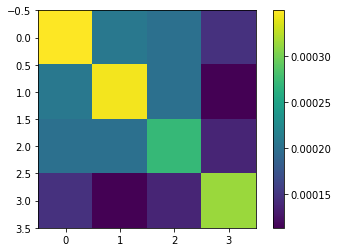

In [24]:
# plot sigma
plt.imshow(sigma_df, interpolation='nearest')
plt.colorbar()
plt.show()

# Markowitz approach

In [25]:
# Let us try many portfolios composed different proportion (weights) of the selected assets (stocks)
p_ret          = []     # Empty list for the portfolio returns
p_vol          = []     # Empty list for the portfolio volatilities
p_weights      = []     # Empty list the weights
num_portfolios = 10000  # The higher, the better with increasing number of assets (number of trials)
for port in range(num_portfolios):
    weights = np.random.random(num_assets) # Random weights vector
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, mu)          # Total Returns: sum of the weight of the asset x the corresponding individual return 
    p_ret.append(returns)
    var     = sigma_df.mul(weights, axis=0).mul(weights, axis=1).sum().sum() #Variância do portfolio
    sd      = np.sqrt(var)                 # Standard Deviation
    ann_sd  = sd*np.sqrt(250)              # Annual Standard Deviation  == Volatility (measure of risk)
    p_vol.append(ann_sd)

# Create Risk x Return DataFrame
data = {'Return':p_ret, 'Risk':p_vol}
for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [26]:
portfolios  = pd.DataFrame(data)
portfolios.head(n = 10) # View the first n portfolios of 10000 portfolios created with random weights

,Return,Risk,AAPL weight,AMZN weight,GOOGL weight,NKE weight
0,0.346979,0.227479,0.295892,0.241042,0.180194,0.282872
1,0.363570,0.237601,0.301962,0.334257,0.266798,0.096983
2,0.314868,0.224995,0.018534,0.319988,0.327979,0.333498
3,0.338532,0.234938,0.087368,0.387016,0.398912,0.126705
4,0.366964,0.241808,0.275171,0.402969,0.259208,0.062651
5,0.365769,0.241454,0.377990,0.203927,0.371130,0.046954
6,0.343455,0.228270,0.216608,0.279610,0.301241,0.202540
7,0.345748,0.228458,0.318282,0.159776,0.283613,0.238330
8,0.344409,0.226868,0.246320,0.289394,0.184272,0.280013
9,0.333421,0.226438,0.275420,0.101828,0.333581,0.289171


## Efficient frontier

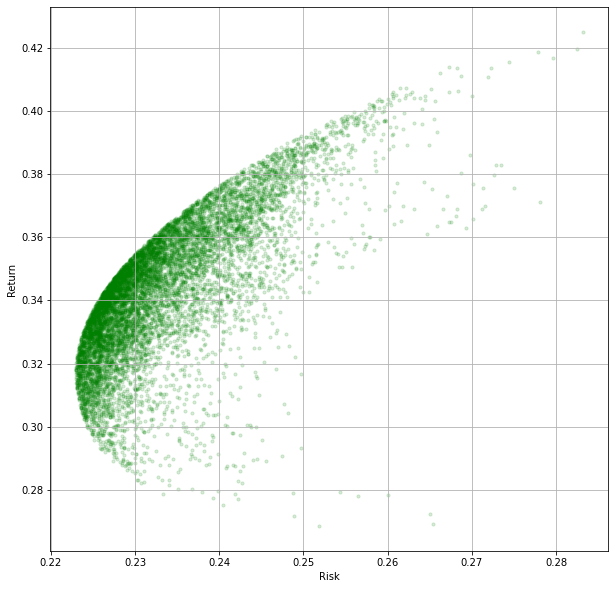

In [27]:
# Plot Efficient frontier
portfolios.plot.scatter(x='Risk', y='Return', c='green', marker='o', s=10, alpha=0.15, grid=True, figsize=[10,10]);

## Risk-free return and Shape Ratio

- **Risk-free rate of return ($R_f$)**

The risk-free rate of return is the return on an investment without risk, i. e., the (best) return investors can expect for taking no risk.

- **Sharpe Ratio (SR)**

The ratio is the average return earned in excess of the risk-free rate:

$ SR = \frac{R_p - R_f}{\sigma_o}, $

where:

$R_p$ is the return of the portfolio, $R_f$ is the risk-free return rate, and $\sigma_p$ is the volatility (standard deviation of price fluctuations).

*The ideal risk portfolio is the one with the highest Sharpe Ratio.*

In [28]:
# Portfolio composition with the highest Sharpe Ratio for a given risk-free factor
rf0          = 0.02   # risk-free rate of return available for investors (2%)
opt_ris_por0 = portfolios.iloc[((portfolios['Return']-rf0)/portfolios['Risk']).idxmax()]
opt_ris_por0

Return          0.389874
Risk            0.248015
AAPL weight     0.525098
AMZN weight     0.330692
GOOGL weight    0.000235
NKE weight      0.143975
Name: 6553, dtype: float64

In [29]:
# Portfolio composition (weights) with minimal risk
min_vol_port = portfolios.iloc[portfolios['Risk'].idxmin()]
min_vol_port

Return          0.317231
Risk            0.222946
AAPL weight     0.117139
AMZN weight     0.206041
GOOGL weight    0.307884
NKE weight      0.368936
Name: 460, dtype: float64

In [30]:
# Portfolio composition (weights) with maximum return
max_ret_port = portfolios.iloc[portfolios['Return'].idxmax()]
max_ret_port

Return          0.425176
Risk            0.283206
AAPL weight     0.890197
AMZN weight     0.090865
GOOGL weight    0.014366
NKE weight      0.004572
Name: 5759, dtype: float64

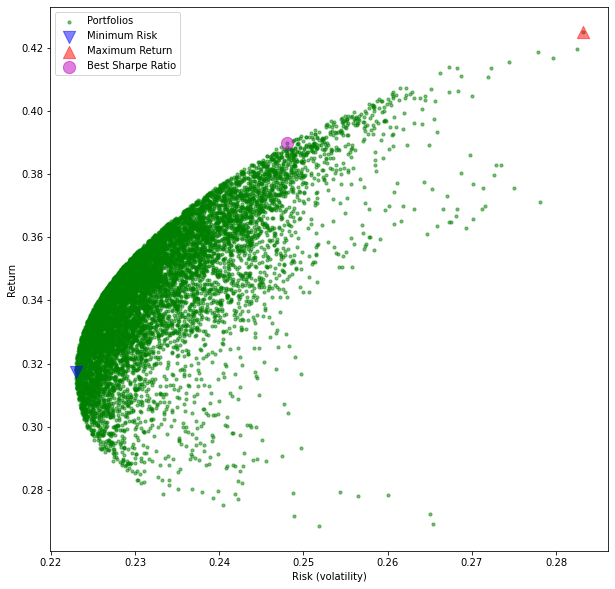

In [31]:
# Portfolio with: minimum risk, maximum return and optimal sharpe ratio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Risk'], portfolios['Return'],  marker='o', s=10, alpha=0.5, c ='green', label = 'Portfolios');
plt.scatter(min_vol_port[1], min_vol_port[0], c='b',     marker='v', s=150, alpha=0.5, label = 'Minimum Risk');
plt.scatter(max_ret_port[1], max_ret_port[0], c='r',     marker='^', s=150, alpha=0.5,label = 'Maximum Return');
plt.scatter(opt_ris_por0[1], opt_ris_por0[0], c='m',     marker='o', s=150, alpha=0.5,label = 'Best Sharpe Ratio');
plt.xlabel('Risk (volatility)')
plt.ylabel('Return')
plt.legend(loc = 'best');

# Quantum Computing Approach

The problem is a bit different. We want to solve optimization problem with the following objective function (OF): \begin{split}\begin{aligned} \min_{x \in \{0, 1\}^n} q x^T \sigma x - \mu^T x\\ \text{restriced to: } 1^T x = B \end{aligned}\end{split}
where:
- $x \in \{0,1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x = 1$) and which not to pick ($x =0$),
- $\mu \in \mathbf{R}^n$ defines the expected returns for the assets, 
- $\sigma \in \mathbf{R}^{n\times n}$  specifies the covariances between the assets,
- $q>0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$ available.

Reference: https://qiskit.org/documentation/finance/tutorials/01_portfolio_optimization.html

This section shows how to use the Variational Quantum Eigensolver (VQE) and the Quantum Approximate Optimization Algorithm (QAOA) to find the optimal solution for a given set of parameters.

In [32]:
q       = 0.5             # set risk factor
budget  = num_assets // 2 # set budget (number of stocks to pick). We choose "2" 
                          # just to check if it returns the best 2 stocks with Markowitz approach
#                          
penalty = num_assets      # set parameter to scale the budget penalty term

# Note: df to array (mu.values, sigma.values)
mu      = mu_df.values
sigma   = sigma_df.values
qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

In [33]:
# functions for better output shape
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value of objective function {:.4f}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue of OF\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

## Exact eigensolver (Numpy)

In [34]:
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result            = exact_eigensolver.run()
print_result(result)

Optimal: selection [1 1 0 0], value of objective function -0.8120

----------------- Full result ---------------------
selection	value of OF		probability
---------------------------------------------------
 [1 1 0 0]	-0.8120		1.0000
 [1 1 1 1]	14.6285		0.0000
 [0 1 1 1]	3.0604		0.0000
 [1 0 1 1]	3.0078		0.0000
 [0 0 1 1]	-0.5601		0.0000
 [1 1 0 1]	2.9315		0.0000
 [0 1 0 1]	-0.6364		0.0000
 [1 0 0 1]	-0.6890		0.0000
 [0 0 0 1]	3.7433		0.0000
 [1 1 1 0]	2.8848		0.0000
 [0 1 1 0]	-0.6831		0.0000
 [1 0 1 0]	-0.7358		0.0000
 [0 0 1 0]	3.6965		0.0000
 [0 1 0 0]	3.6202		0.0000
 [1 0 0 0]	3.5676		0.0000
 [0 0 0 0]	16.0000		0.0000


In [35]:
# qiskit backend CFG
backend = Aer.get_backend('statevector_simulator')

## Variational Quantum Eigensolver (VQE)

In [36]:
#VQE
seed    = 50
cobyla  = COBYLA()
cobyla.set_options(maxiter=500)
ry      = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe     = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed
#
qi_VQE  = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result  = vqe.run(qi_VQE)
#
print_result(result)

Optimal: selection [1. 1. 0. 0.], value of objective function -0.8120

----------------- Full result ---------------------
selection	value of OF		probability
---------------------------------------------------
 [1 1 0 0]	-0.8120		0.8524
 [0 1 1 0]	-0.6831		0.0957
 [0 0 1 1]	-0.5601		0.0384
 [0 1 0 1]	-0.6364		0.0081
 [1 0 0 1]	-0.6890		0.0042
 [1 0 1 0]	-0.7358		0.0004
 [1 0 1 1]	3.0078		0.0004
 [0 0 0 1]	3.7433		0.0002
 [1 1 1 0]	2.8848		0.0001
 [1 1 1 1]	14.6285		0.0000
 [0 0 0 0]	16.0000		0.0000
 [1 0 0 0]	3.5676		0.0000
 [1 1 0 1]	2.9315		0.0000
 [0 1 1 1]	3.0604		0.0000
 [0 1 0 0]	3.6202		0.0000
 [0 0 1 0]	3.6965		0.0000


Note how the solver penalize portfolios with number of stocks different of the budget == 2. For example, check the high values of the objective function for [0 0 0 0] and [1 1 1 1].

# Quantum Approximate Optimization Algorithm (QAOA)

In [37]:
#QAOA
seed    = 123
cobyla  = COBYLA()
cobyla.set_options(maxiter=250)
qaoa    = QAOA(qubitOp, cobyla, 3)
qaoa.random_seed = seed
#
qi_QAOA = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result  = qaoa.run(qi_QAOA)
#
print_result(result)

Optimal: selection [1. 1. 0. 0.], value of objective function -0.8120

----------------- Full result ---------------------
selection	value of OF		probability
---------------------------------------------------
 [1 1 0 0]	-0.8120		0.2334
 [1 0 1 0]	-0.7358		0.1356
 [0 1 1 0]	-0.6831		0.1236
 [1 0 0 1]	-0.6890		0.0953
 [0 1 0 1]	-0.6364		0.0883
 [0 0 1 1]	-0.5601		0.0708
 [1 1 1 0]	2.8848		0.0581
 [1 0 0 0]	3.5676		0.0434
 [0 1 0 0]	3.6202		0.0329
 [1 1 0 1]	2.9315		0.0288
 [0 0 1 0]	3.6965		0.0211
 [0 1 1 1]	3.0604		0.0183
 [1 0 1 1]	3.0078		0.0160
 [1 1 1 1]	14.6285		0.0156
 [0 0 0 1]	3.7433		0.0156
 [0 0 0 0]	16.0000		0.0032


Again, note how the solver penalize portfolios with number of stocks different of the budget == 2. For example, check the high values of the objective function for [0 0 0 0] and [1 1 1 1].